In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import \
                accuracy_score, \
                classification_report, \
                cohen_kappa_score, \
                matthews_corrcoef, \
                confusion_matrix, \
                roc_auc_score

                
import xgboost as xgb

In [2]:
def eval_metrics(y_true, y_pred):
    kappa = metrics.cohen_kappa_score(y_true, y_pred)
    #print(f"Cohen's Kappa: {kappa:.2f}")
    
    # Calculate confusion matrix
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate TPR (True Positive Rate), TNR (True Negative Rate), Precision
    TPR = tp / (tp + fn)
    TNR = tn / (tn + fp)
    precision = tp / (tp + fp)
    
    # print(f"True Positive Rate (TPR): {TPR:.2f}")
    # print(f"True Negative Rate (TNR): {TNR:.2f}")
    # print(f"Precision: {precision:.2f}")

    return {'kappa':kappa,'TPR':TPR,'TNR':TNR,'precision':precision}

def evaluate_performance(y_true,y_pred,pred_prob='NA'):
    cr = classification_report(y_true,y_pred)
    filtered_cr = [ line for line in cr.split('\n') if len(line)!=0]

    precision_0 = float(filtered_cr[1].split()[1])
    recall_0 = float(filtered_cr[1].split()[2])
    f1_0 = float(filtered_cr[1].split()[3])
    
    precision_1 = float(filtered_cr[2].split()[1])
    recall_1 = float(filtered_cr[2].split()[2])
    f1_1 = float(filtered_cr[2].split()[3])

    balanced_accuracy = (recall_0 + recall_1)/2
    acc_score = accuracy_score(y_true,y_pred)
    cohen_kappa = cohen_kappa_score(y_true,y_pred)
    matthews_corrcoef_score = matthews_corrcoef(y_true,y_pred)
    
    if pred_prob != 'NA':
        roc_auc = roc_auc_score(y_true,pred_prob)
    else:
        roc_auc = pred_prob
    

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    temp = dict(
        precision_0 = precision_0,
        precision_1 = precision_1,
        recall_0 = recall_0,
        recall_1 = recall_1,
        f1_0 = f1_0,
        f1_1 = f1_1,
        accuracy = acc_score,
        balanced_accuracy = balanced_accuracy,
        cohen_kappa = cohen_kappa,
        matthews_corrcoef_score = matthews_corrcoef_score,
        roc_auc_score = roc_auc,
        
        tn = tn,
        fp = fp,
        fn = fn,
        tp = tp
    )

    return temp


## Data Loading

In [3]:
df = pd.read_csv(r"E:\HILLUL\Nagamani Sir\TAPOS-KU-INTERN\COMPILING-MTUNE-REQUIREMENTS\1 Cell-Line Dataset ghost VS mtune\TGF-B Train FP\AtomPairs2DCount.csv")

# Set a seed for reproducibility (e.g., 42)
seed = 42

# Shuffle the DataFrame with the seed
df = df.sample(frac=1, random_state=seed)

# Class wise splitting

### Number of Samples for each Class

In [4]:
label_0s = df[df['Name']==0]
label_1s = df[df['Name']==1]
print('label_0s :',len(label_0s),'\nlabel_1s :',len(label_1s))

size = len(label_1s)
print('size :',size)

label_0s : 175676 
label_1s : 1675
size : 1675


### 30 Samples Test Splitting

In [5]:
num_test_samples = 30

train_df = pd.concat([
    label_1s[num_test_samples: ],
    label_0s[num_test_samples: ]
])


train_df = train_df.sample(frac=1, random_state=seed)

test_df = pd.concat([
    label_1s[: num_test_samples],
    label_0s[: num_test_samples]
])

X_train, y_train = train_df.drop('Name',axis=1), train_df['Name']
X_test, y_test = test_df.drop('Name',axis=1), test_df['Name']

print('X_train ---> active :',len([ label for label in y_train if label == 1]),end = '\t')
print('inactive :',len( [ label for label in y_train if label == 0] ))

print('X_test ---> active :',len([ label for label in y_test if label == 1]),end = '\t')
print('inactive :',len( [ label for label in y_test if label == 0] ))

X_train ---> active : 1645	inactive : 175646
X_test ---> active : 30	inactive : 30


### 20 percent test set

In [8]:
X = df.drop('Name',axis=1)
y = df['Name'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('X_train ---> active :',len([ label for label in y_train if label == 1]),end = '\t')
print('inactive :',len( [ label for label in y_train if label == 0] ))

print('X_test ---> active :',len([ label for label in y_test if label == 1]),end = '\t')
print('inactive :',len( [ label for label in y_test if label == 0] ))

X_train ---> active : 1340	inactive : 140540
X_test ---> active : 335	inactive : 35136


### Model Training

In [6]:
xgb_model = xgb.XGBClassifier(
    # **best_params
    random_state = 42
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

## Standard Threshold thres = 0.5

In [7]:
train_performance_df = pd.DataFrame()
train_pred_df = pd.DataFrame()

### Training Set Performance

In [8]:
pred_prob = xgb_model.predict_proba(X_train)[:,1].tolist()
y_true = y_train.tolist()
y_pred = [1 if p >= 0.5 else 0 for p in pred_prob]

train_pred_df['y_true'] = y_true
train_pred_df['pred_prob'] = pred_prob
train_pred_df['standard'] = y_pred

vals = dict(method = 'Standard', thres = '0.5')
temp = evaluate_performance(y_true,y_pred,pred_prob)
vals.update(temp)
train_performance_df[len(train_performance_df.columns)] = vals
train_performance_df

,0
method,Standard
thres,0.5
precision_0,0.99
precision_1,0.99
recall_0,1.0
recall_1,0.35
f1_0,1.0
f1_1,0.51
accuracy,0.993903
balanced_accuracy,0.675


### Testing Set Performance

In [9]:
test_performance_df = pd.DataFrame()
test_pred_df = pd.DataFrame()

In [10]:
pred_prob = xgb_model.predict_proba(X_test)[:,1].tolist()
y_true = y_test.tolist()
y_pred = [1 if p >= 0.5 else 0 for p in pred_prob]

test_pred_df['y_true'] = y_true
test_pred_df['pred_prob'] = pred_prob
test_pred_df['standard'] = y_pred

vals = dict(method = 'Standard', thres = '0.5')
temp = evaluate_performance(y_true,y_pred,pred_prob)

vals.update(temp)
test_performance_df[len(test_performance_df.columns)] = vals
test_performance_df

,0
method,Standard
thres,0.5
precision_0,0.53
precision_1,1.0
recall_0,1.0
recall_1,0.1
f1_0,0.69
f1_1,0.18
accuracy,0.55
balanced_accuracy,0.55


# M-Tune

In [11]:
mean_thres = train_pred_df['pred_prob'].mean()
mean_thres

0.009306526714436993

In [12]:
train_pred_df.head()

,y_true,pred_prob,standard
0,0,0.005886,0
1,0,0.001553,0
2,0,0.003904,0
3,0,0.022739,0
4,0,0.001039,0


### Training set Performance

In [13]:
train_pred_df['M-Tune'] = [1 if p >= mean_thres else 0 for p in train_pred_df['pred_prob'].tolist() ]

pred_prob = train_pred_df['pred_prob'].tolist()
y_true = train_pred_df['y_true'].tolist()
y_pred = train_pred_df['M-Tune'].tolist()

vals = dict(method = 'M-Tune', thres = mean_thres)
temp = evaluate_performance(y_true,y_pred,pred_prob)

vals.update(temp)
train_performance_df[len(train_performance_df.columns)] = vals
train_performance_df

,0,1
method,Standard,M-Tune
thres,0.5,0.009307
precision_0,0.99,1.0
precision_1,0.99,0.06
recall_0,1.0,0.86
recall_1,0.35,0.96
f1_0,1.0,0.92
f1_1,0.51,0.11
accuracy,0.993903,0.85865
balanced_accuracy,0.675,0.91


### Testing Set Performance

In [14]:
test_pred_df['M-Tune'] = [1 if p >= mean_thres else 0 for p in test_pred_df['pred_prob'].tolist() ]

pred_prob = test_pred_df['pred_prob'].tolist()
y_true = test_pred_df['y_true'].tolist()
y_pred = test_pred_df['M-Tune'].tolist()

vals = dict(method = 'M-Tune', thres = mean_thres)
temp = evaluate_performance(y_true,y_pred,pred_prob)

vals.update(temp)
test_performance_df[len(test_performance_df.columns)] = vals
test_performance_df

,0,1
method,Standard,M-Tune
thres,0.5,0.009307
precision_0,0.53,0.7
precision_1,1.0,0.83
recall_0,1.0,0.87
recall_1,0.1,0.63
f1_0,0.69,0.78
f1_1,0.18,0.72
accuracy,0.55,0.75
balanced_accuracy,0.55,0.75


# Visualization

In [27]:
# Extracting Classwise Prediction Probabilities
pred_proba = train_pred_df['pred_prob']
data0 = train_pred_df[train_pred_df['y_true']==0]['pred_prob']
data1 = train_pred_df[train_pred_df['y_true']==1]['pred_prob']

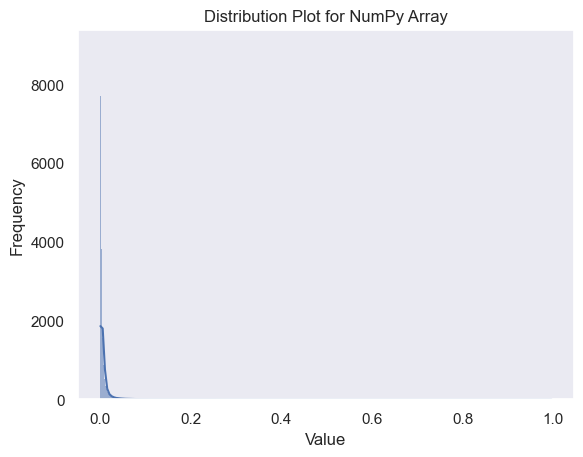

In [29]:
# Set the style for the plot
sns.set(style="darkgrid")

# Create a distribution plot
sns.histplot(pred_proba, kde=True
             #,label='Predicted Probabilities'
            )

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution Plot for NumPy Array')
plt.grid(False)
#plt.legend()
plt.savefig('TGF-B-AtomPairs2DCount - Pred-Prob.png',dpi=300)
# Show the plot
plt.show()

## Zooming in on Scale

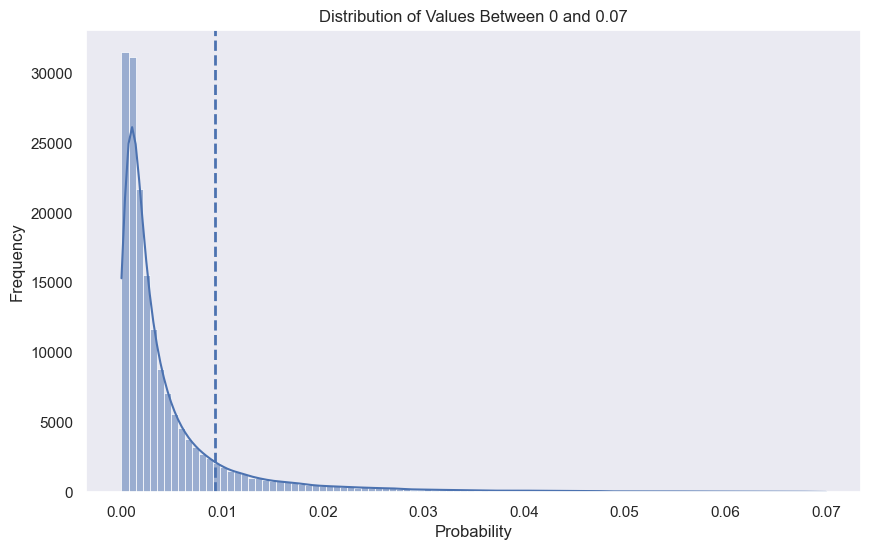

In [31]:
upper_limit = 0.015
upper_limit = 0.07

# Filter the array to include only values between 0 and upper limit
filtered_data = pred_proba[(pred_proba >= 0) & (pred_proba <= upper_limit)]

# Plot the distribution using Seaborn
plt.figure(figsize=(10, 6),facecolor='w')
sns.histplot(filtered_data, bins=100, kde=True,stat='count')
plt.title(f'Distribution of Values Between 0 and {upper_limit}')
plt.xlabel('Probability')
plt.ylabel('Frequency')

plt.axvline(
    x=mean_thres,
    color ='b' , 
    linestyle='--',
    linewidth=2
    #,label= f"Mean - {round(t.loc['mean','whole'],4)}"
)
plt.grid(False)

# plt.legend()
plt.savefig('TGF-B-AtomPairs2DCount - Zoomed-Pred-Prob.png',dpi=300)
plt.show()

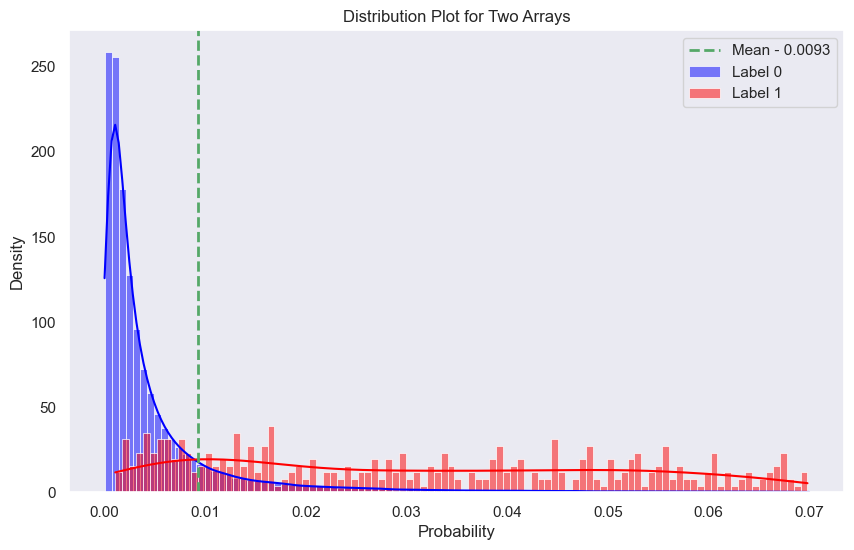

In [33]:
lower_limit = 0
upper_limit = 0.07

# Filter the array to include only values between 0 and 0.1
filtered_data0 = data0[(data0 >= lower_limit) & (data0 <= upper_limit)]
filtered_data1 = data1[(data1 >= lower_limit) & (data1 <= upper_limit)]

# Plot the distributions
plt.figure(figsize=(10, 6),facecolor='white')
# plt.style.use('seaborn-white')

# Plot for the first dataset
sns.histplot(
    #data0, 
    filtered_data0,
    bins=100, kde=True, color='blue',  label='Label 0', stat="density"
)

# Plot for the second dataset
sns.histplot(
    #data1, 
    filtered_data1,
    bins=100, kde=True, color='red',  label='Label 1', stat="density"
)

# Add labels and title
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Distribution Plot for Two Arrays')
plt.legend()

plt.axvline(
    x=mean_thres,
    color ='g' , 
    linestyle='--',
    linewidth=2,
    label = f"Mean - {round(mean_thres,4)}"
)
plt.legend()
plt.grid(False)
plt.savefig('TGF-B-AtomPairs2DCount - Zoomed Class-wise-Prediction Probabality.png', dpi = 300 )
# Show the plot
plt.show()

## TP - Frequency

In [35]:
upper_limit = 0.03

def plot_distribution(data, title,figname,upper_limit=1):
    filtered_data = data[(data >= 0) & (data <= upper_limit)]
    
    plt.figure(figsize=(10, 6))
    sns.histplot(filtered_data, bins=100, kde=True, stat = 'count')
    plt.title(title)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.axvline(x=mean_thres,color ='b' , linestyle='--',linewidth=2,
                #label=f"Mean - {round(t.loc['mean','whole'],4)}"
               )
    plt.grid(False)
    plt.savefig(figname+'.png',dpi=300)
    #plt.legend()
    plt.show()

In [39]:
confusion_matrix(test_pred_df['y_true'].tolist(),test_pred_df['M-Tune'].tolist())

array([[26,  4],
       [11, 19]], dtype=int64)

In [43]:
# Filter for true positives
tp = test_pred_df[
    (test_pred_df['y_true'] == 1) & 
    (test_pred_df['M-Tune'] == test_pred_df['y_true'])
]

19


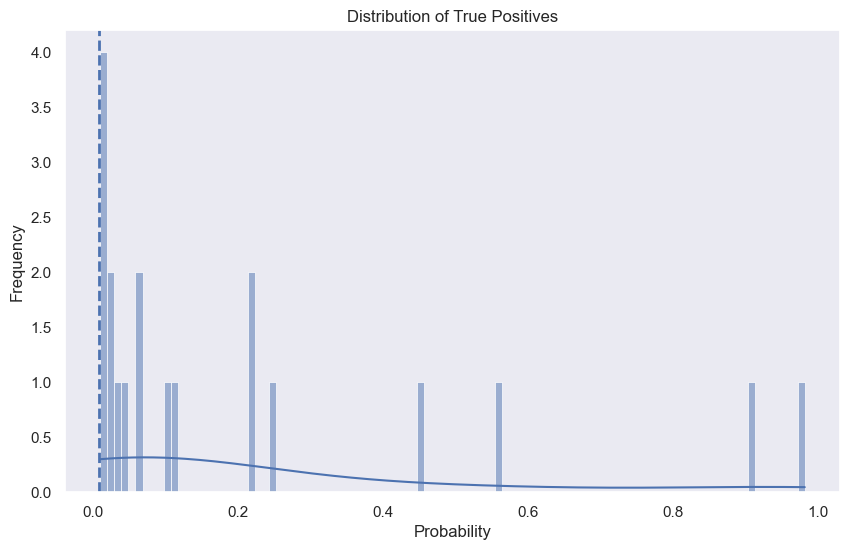

In [44]:
#Plotting TP distribution
print(len(tp))
plot_distribution(tp['pred_prob'], f'Distribution of True Positives','TGF-B-AtomPairs2DCount_TP')

In [45]:
# Filter for true negatives
tn = test_pred_df[
    (test_pred_df['y_true'] == 0) & 
    (test_pred_df['M-Tune'] == test_pred_df['y_true'])
]

26


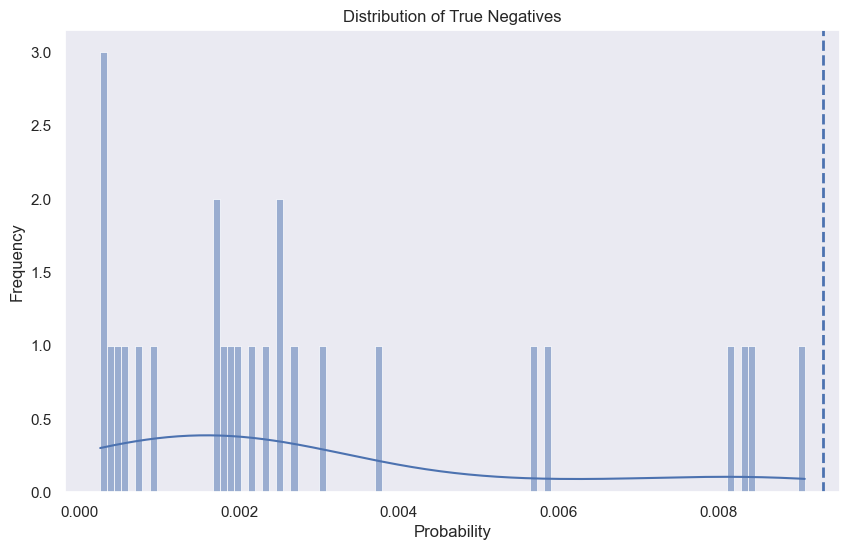

In [46]:
print(len(tn))
#Plotting TN distribution
plot_distribution(tn['pred_prob'], 'Distribution of True Negatives','TGF-B-AtomPairs2DCount_TN',upper_limit=0.010)

In [48]:
# Filter for false positives
fp = test_pred_df[
    (test_pred_df['y_true'] == 0) & 
    (test_pred_df['M-Tune'] != test_pred_df['y_true'])
]

4


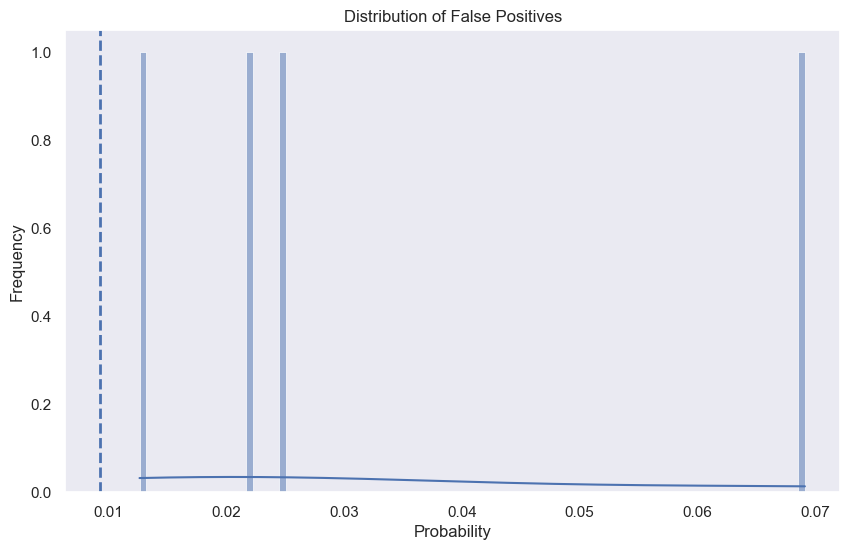

In [50]:
#Plotting FP distribution
print(len(fp))
plot_distribution(fp['pred_prob'], 'Distribution of False Positives','TGF-B-AtomPairs2DCount_FP')

In [51]:
# Filter for false negatives
fn = test_pred_df[
    (test_pred_df['y_true'] == 1) & 
    (test_pred_df['M-Tune'] != test_pred_df['y_true'])
]

11


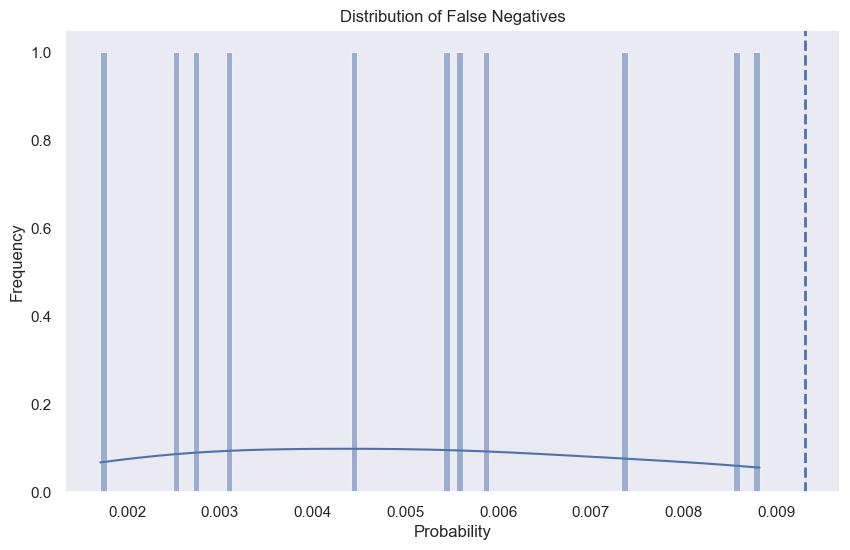

In [52]:
#Plotting FN distribution
print(len(fn))
plot_distribution(fn['pred_prob'], 'Distribution of False Negatives','TGF-B-AtomPairs2DCount_FN')

## External Dataset Evaluation

In [15]:
ext_df = pd.read_csv(r'E:\HILLUL\Nagamani Sir\TAPOS-KU-INTERN\COMPILING-MTUNE-REQUIREMENTS\1 Cell-Line Dataset ghost VS mtune\TGF-B External FP\External_AtomPairs2DCount.csv')
ext_df

,Name,APC2D1_C_C,APC2D1_C_N,APC2D1_C_O,APC2D1_C_S,APC2D1_C_P,APC2D1_C_F,APC2D1_C_Cl,APC2D1_C_Br,APC2D1_C_I,...,APC2D10_I_I,APC2D10_I_B,APC2D10_I_Si,APC2D10_I_X,APC2D10_B_B,APC2D10_B_Si,APC2D10_B_X,APC2D10_Si_Si,APC2D10_Si_X,APC2D10_X_X
0,0,13.0,8.0,3.0,0.0,0.0,3.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,13.0,8.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,14.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,13.0,8.0,1.0,2.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,17.0,8.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39167,0,13.0,5.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39168,0,16.0,5.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39169,0,12.0,4.0,4.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39170,0,18.0,6.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
ext_X = ext_df.drop('Name', axis=1)
ext_y = ext_df['Name']

In [17]:
ext_pred_df = pd.DataFrame()
ext_pred_df['y_true'] = ext_y.tolist()
ext_pred_df['pred_prob'] = xgb_model.predict_proba(ext_X)[:,1].tolist()
ext_pred_df['Standard'] = [1 if p>= 0.5 else 0 for p in ext_pred_df['pred_prob'].tolist() ]
ext_pred_df['M-Tune'] = [1 if p>= mean_thres else 0 for p in ext_pred_df['pred_prob'].tolist() ]
ext_pred_df

,y_true,pred_prob,Standard,M-Tune
0,0,0.076064,0,1
1,0,0.000862,0,0
2,0,0.003128,0,0
3,0,0.021289,0,1
4,0,0.005673,0,0
...,...,...,...,...
39167,0,0.015767,0,1
39168,0,0.000858,0,0
39169,0,0.000225,0,0
39170,0,0.005927,0,0


In [25]:
ext_preformance_df = pd.DataFrame()

In [26]:
y_true = ext_pred_df['y_true'].tolist()
y_pred = ext_pred_df['Standard'].tolist()
pred_prob = ext_pred_df['pred_prob'].tolist()

vals = dict(method = 'Standard',thres= 0.5)
temp = evaluate_performance(y_true, y_pred, pred_prob ) 
vals.update(temp)
ext_preformance_df[len(ext_preformance_df.columns)] = vals
ext_preformance_df

,0
method,Standard
thres,0.5
precision_0,0.98
precision_1,0.12
recall_0,0.99
recall_1,0.05
f1_0,0.99
f1_1,0.07
accuracy,0.97945
balanced_accuracy,0.52


In [29]:
y_true = ext_pred_df['y_true'].tolist()
y_pred = ext_pred_df['M-Tune'].tolist()
pred_prob = ext_pred_df['pred_prob'].tolist()

vals = dict(method = 'M-Tune',thres= mean_thres)
temp = evaluate_performance(y_true, y_pred, pred_prob) 
vals.update(temp)
ext_preformance_df[len(ext_preformance_df.columns)] = vals
ext_preformance_df

,0,1
method,Standard,M-Tune
thres,0.5,0.009307
precision_0,0.98,0.99
precision_1,0.12,0.04
recall_0,0.99,0.74
recall_1,0.05,0.66
f1_0,0.99,0.85
f1_1,0.07,0.07
accuracy,0.97945,0.742673
balanced_accuracy,0.52,0.7
